In this notebook, we go through clustering methods over correlation distance matrix,
$d_{i, j} = \sqrt{\frac{1}{2} (1 - \rho_{i, j})}$. Especially, we try out k-means clustering. In k-means algorithm, you need to pick up the number of clusters, K, in advance. To tune this parameter, we introduce clustering quality metric, silhouette coefficient,
$$S_i = \frac{b_i - a_i}{max\{a_i, b_i\}}, \forall i = 1, ..., N$$
, where $b_i$ and $a_i$ are average distance from different cluster points and the same cluster points.

If clustering is completely at random, these two distance would be closer, so $S_i$ would be around zero on the average. The better quality, the close to 1 the metric becomes. To aggregate value on each point, we use the following
$$q = \frac{Mean[S_i]}{Std[S_i]}$$

Our clustering algorithm is briefly the following:
1. Find the best kmeans over 1-K cluster numbers
2. Iterate with different initialization
3. Try further 1 and 2 on set of clusters: $\{q_k | q_k < E[q],  k=1, ..., K\}$

Step 1 and 2 are implemented as `cluster_kmeans_base`. Step 1-3 are implemented as `cluster_kmeans_top`. 

The detail of implementations will be found at finance_ml/clustering.py.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Experiments on Random block Correlation Matrices

We generate correlation matrix, where strong correlation only within the same block.

In [2]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=False, sigma=1)
print(x.shape)
x.head()

(100, 100)


/home/tom/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.648064,0.644821,0.647576,0.642479,0.639008,0.644126,0.651666,0.647596,0.666128,...,0.299155,0.278392,0.297337,0.285519,0.282994,0.296660,0.293405,0.287769,0.309553,0.286408
1,0.648064,1.000000,0.658045,0.656754,0.654702,0.673140,0.662693,0.655241,0.658955,0.667980,...,0.296097,0.290117,0.297914,0.294010,0.293694,0.293246,0.300530,0.296223,0.311582,0.283979
2,0.644821,0.658045,1.000000,0.650236,0.646210,0.655934,0.655079,0.658198,0.654908,0.664291,...,0.295449,0.286718,0.299198,0.292905,0.284607,0.301503,0.303082,0.295743,0.308212,0.294664
3,0.647576,0.656754,0.650236,1.000000,0.651724,0.654731,0.665069,0.651855,0.649429,0.662751,...,0.313131,0.306939,0.312946,0.290307,0.284064,0.304908,0.298216,0.294945,0.311677,0.298423
4,0.642479,0.654702,0.646210,0.651724,1.000000,0.651531,0.640533,0.663029,0.662011,0.668839,...,0.277336,0.267329,0.275726,0.274951,0.270808,0.276549,0.271984,0.279297,0.282825,0.276761


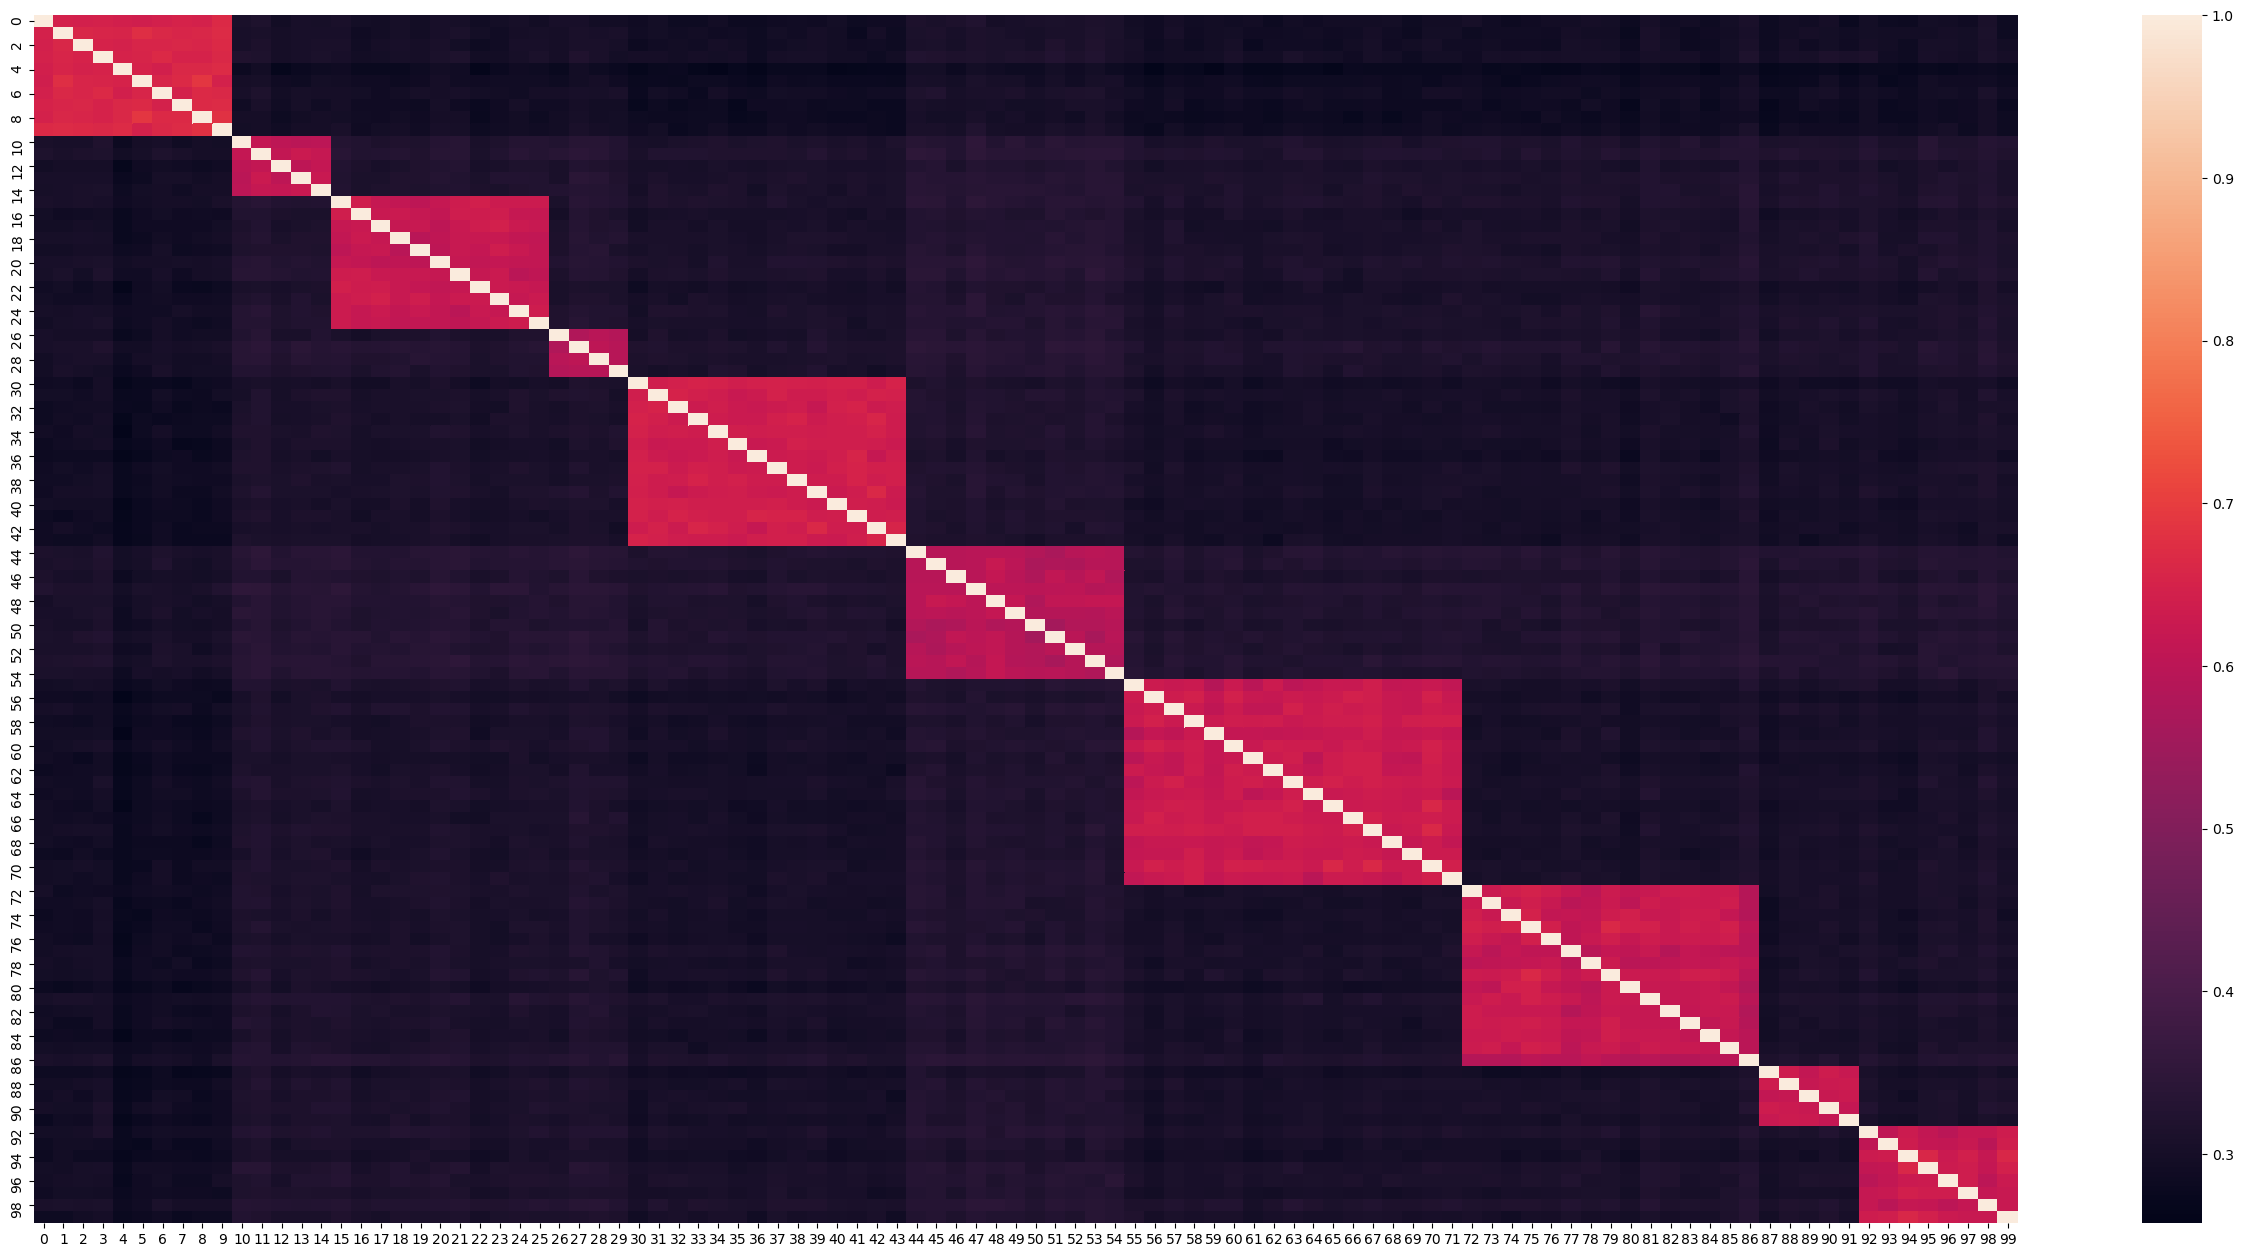

In [3]:
import seaborn as sns

sns.heatmap(x);

Before shuffling, you see several blocks in the correlation matrix.

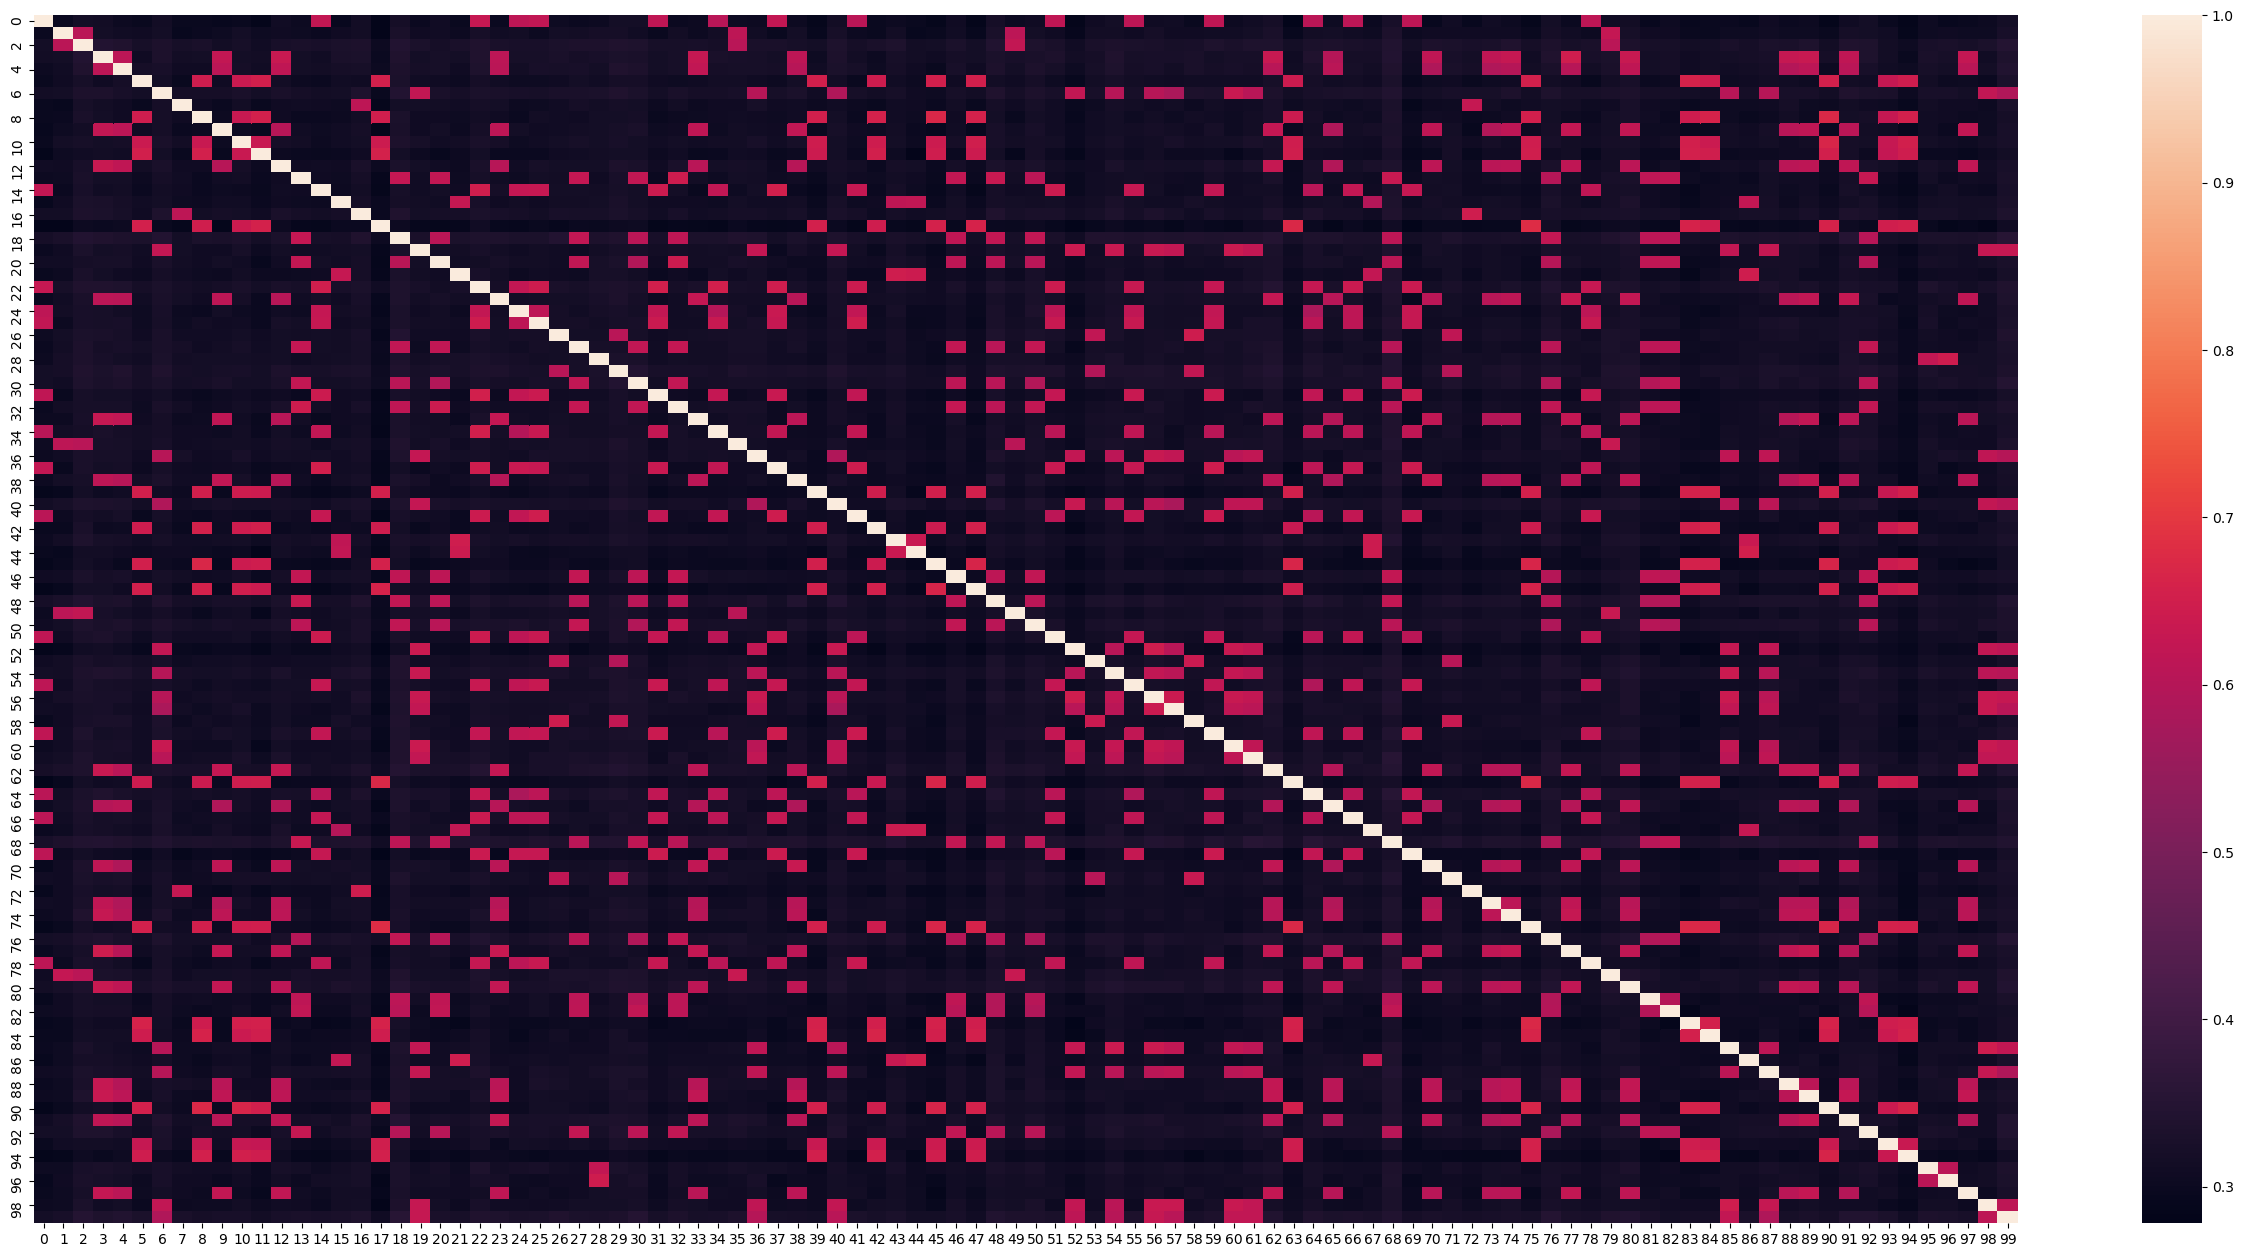

In [4]:
from finance_ml.experiments import get_random_block_corr

x = get_random_block_corr(100, 10, is_shuffle=True, sigma=1)
sns.heatmap(x);

Let's re-find clusters from this matrix.

The number of clusters: 10
{0: [5, 8, 10, 11, 17, 39, 42, 45, 47, 63, 75, 83, 84, 90, 93, 94], 1: [3, 4, 9, 12, 23, 33, 38, 62, 65, 70, 73, 74, 77, 80, 88, 89, 91, 97], 2: [1, 2, 35, 49, 79], 3: [28, 95, 96], 4: [15, 21, 43, 44, 67, 86], 5: [0, 14, 22, 24, 25, 31, 34, 37, 41, 51, 55, 59, 64, 66, 69, 78], 6: [6, 19, 36, 40, 52, 54, 56, 57, 60, 61, 85, 87, 98, 99], 7: [13, 18, 20, 27, 30, 32, 46, 48, 50, 68, 76, 81, 82, 92], 8: [26, 29, 53, 58, 71], 9: [7, 16, 72]}


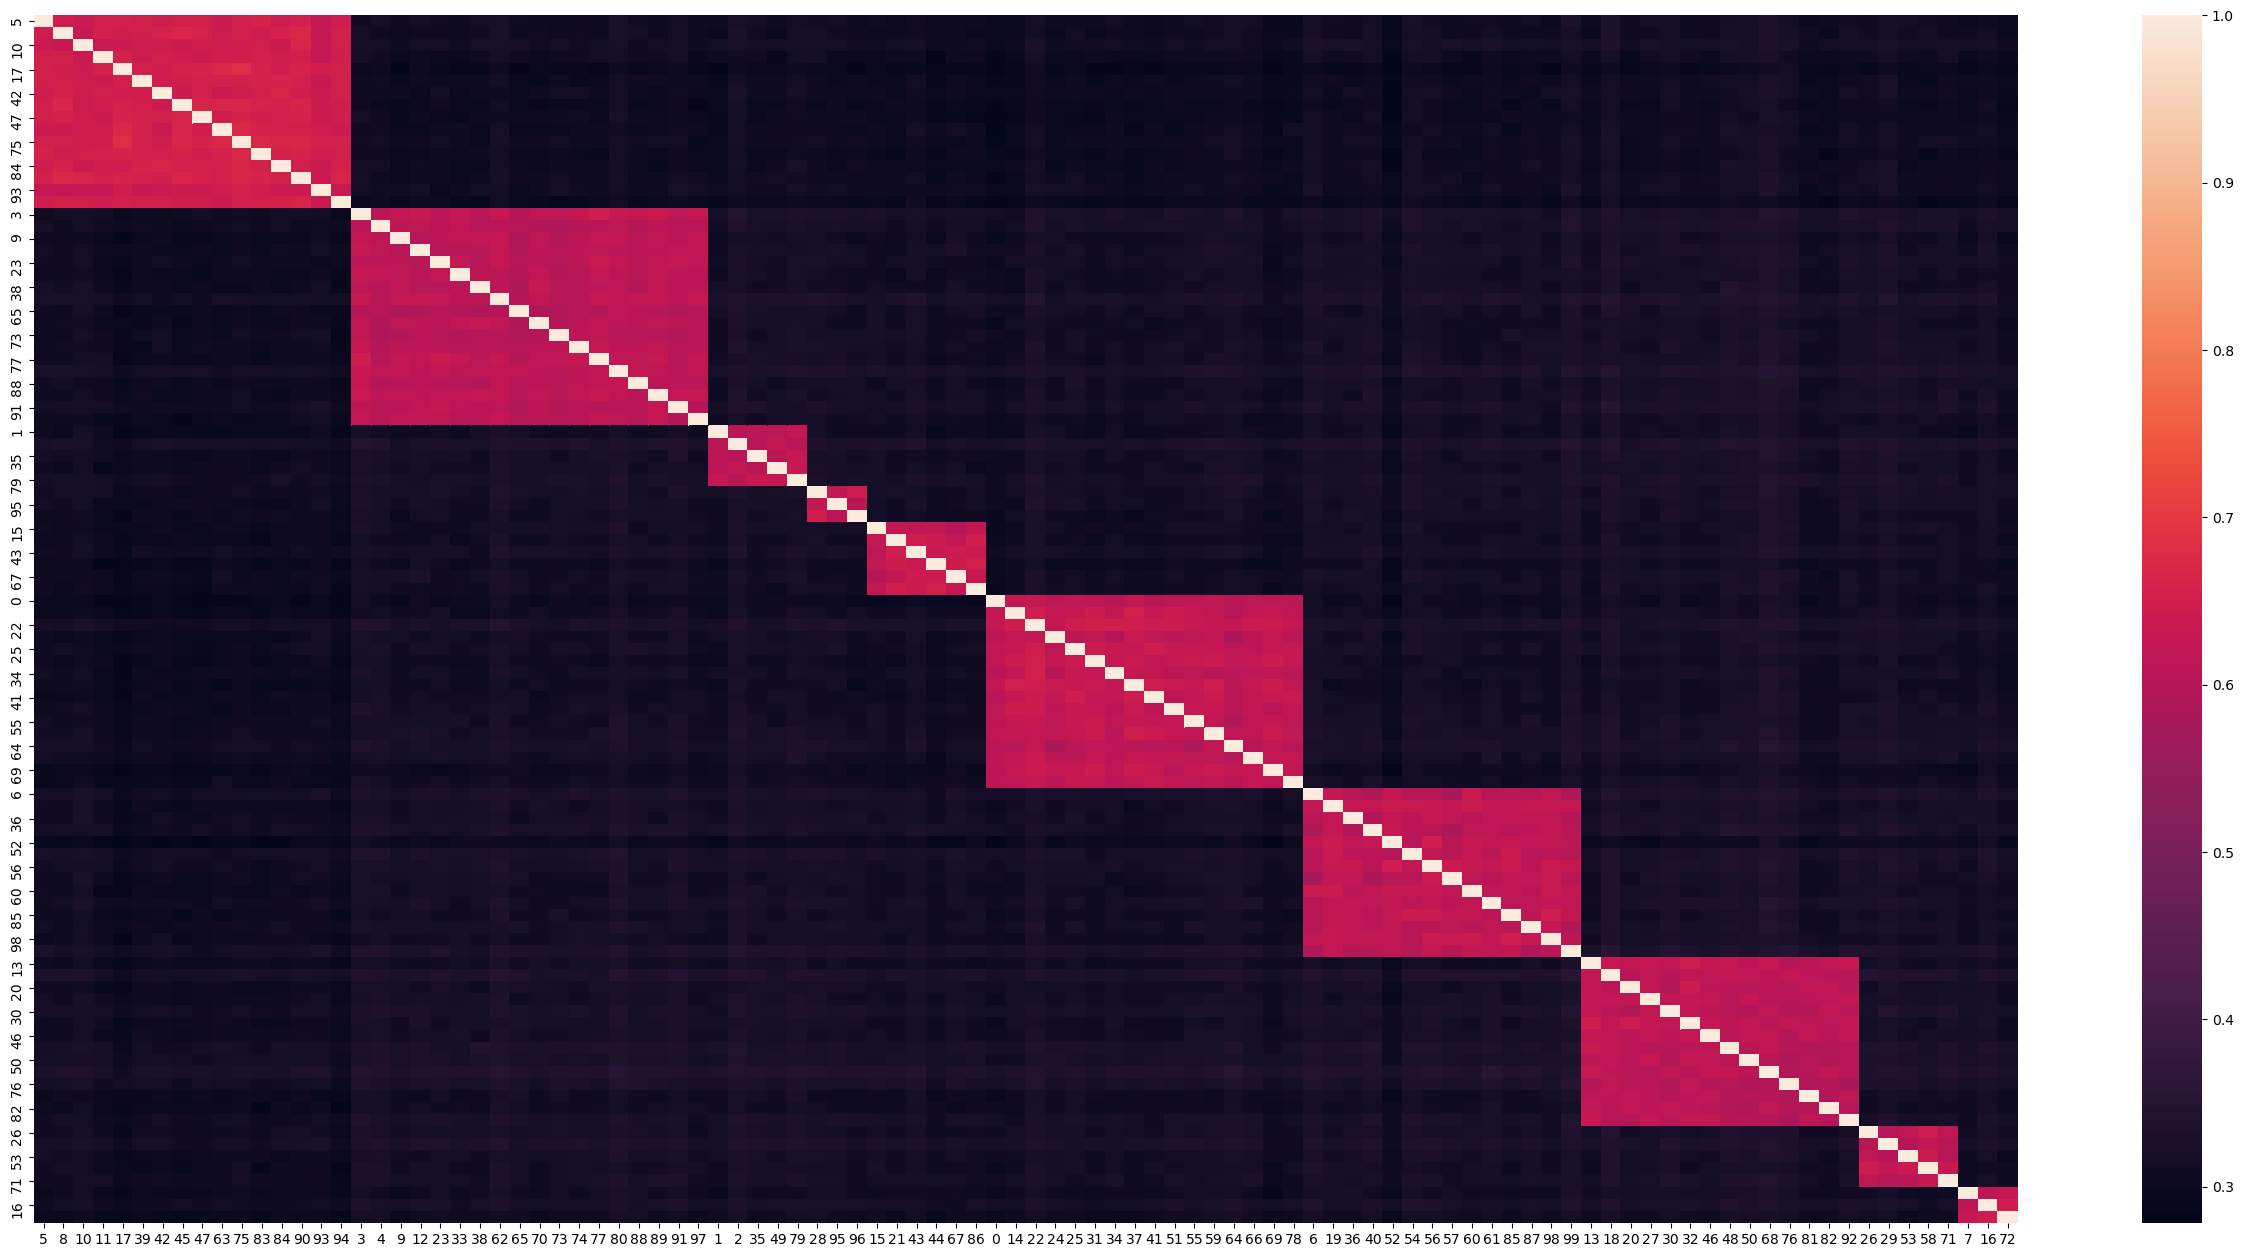

In [5]:
from finance_ml.clustering import cluster_kmeans_top, cluster_kmeans_base
import warnings
warnings.simplefilter('ignore')

corr1, clstrs1, silh1 = cluster_kmeans_top(x, 20, n_init=10)
print(f"The number of clusters: {len(clstrs1)}")
print(clstrs1)
sns.heatmap(corr1);

Successfully reverse correlation back to clustered.

# Stability of the number of clusters

Estimating the number of clusters involves stochasticity. So, we estimate its stability.

In [6]:
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook

from finance_ml.experiments import get_random_block_corr
from finance_ml.clustering import cluster_kmeans_base, cluster_kmeans_top


n_iter = 50
N = 100
KN_ratio = np.linspace(0.1, 0.5, 5)
top_data = list()
data = list()
for i in tqdm_notebook(range(n_iter)):
    for ratio in KN_ratio:
        ratio = round(ratio, 2)
        n_blocks = max(2, int(round(ratio * N)))
        max_num_blocks = max(20, n_blocks + 10)
        x = get_random_block_corr(N, n_blocks=n_blocks, is_shuffle=False, sigma=1)
        corr1, clstrs1, silh1 = cluster_kmeans_top(x, max_num_blocks, n_init=10)
        est_n_blocks = len(clstrs1)
        top_data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
        corr1, clstrs1, silh1 = cluster_kmeans_base(x, max_num_blocks, n_init=10)
        est_n_blocks = len(clstrs1)
        data.append({"K/N": ratio, "E[K]/K": est_n_blocks / n_blocks})
data = pd.DataFrame(data)
top_data = pd.DataFrame(top_data)

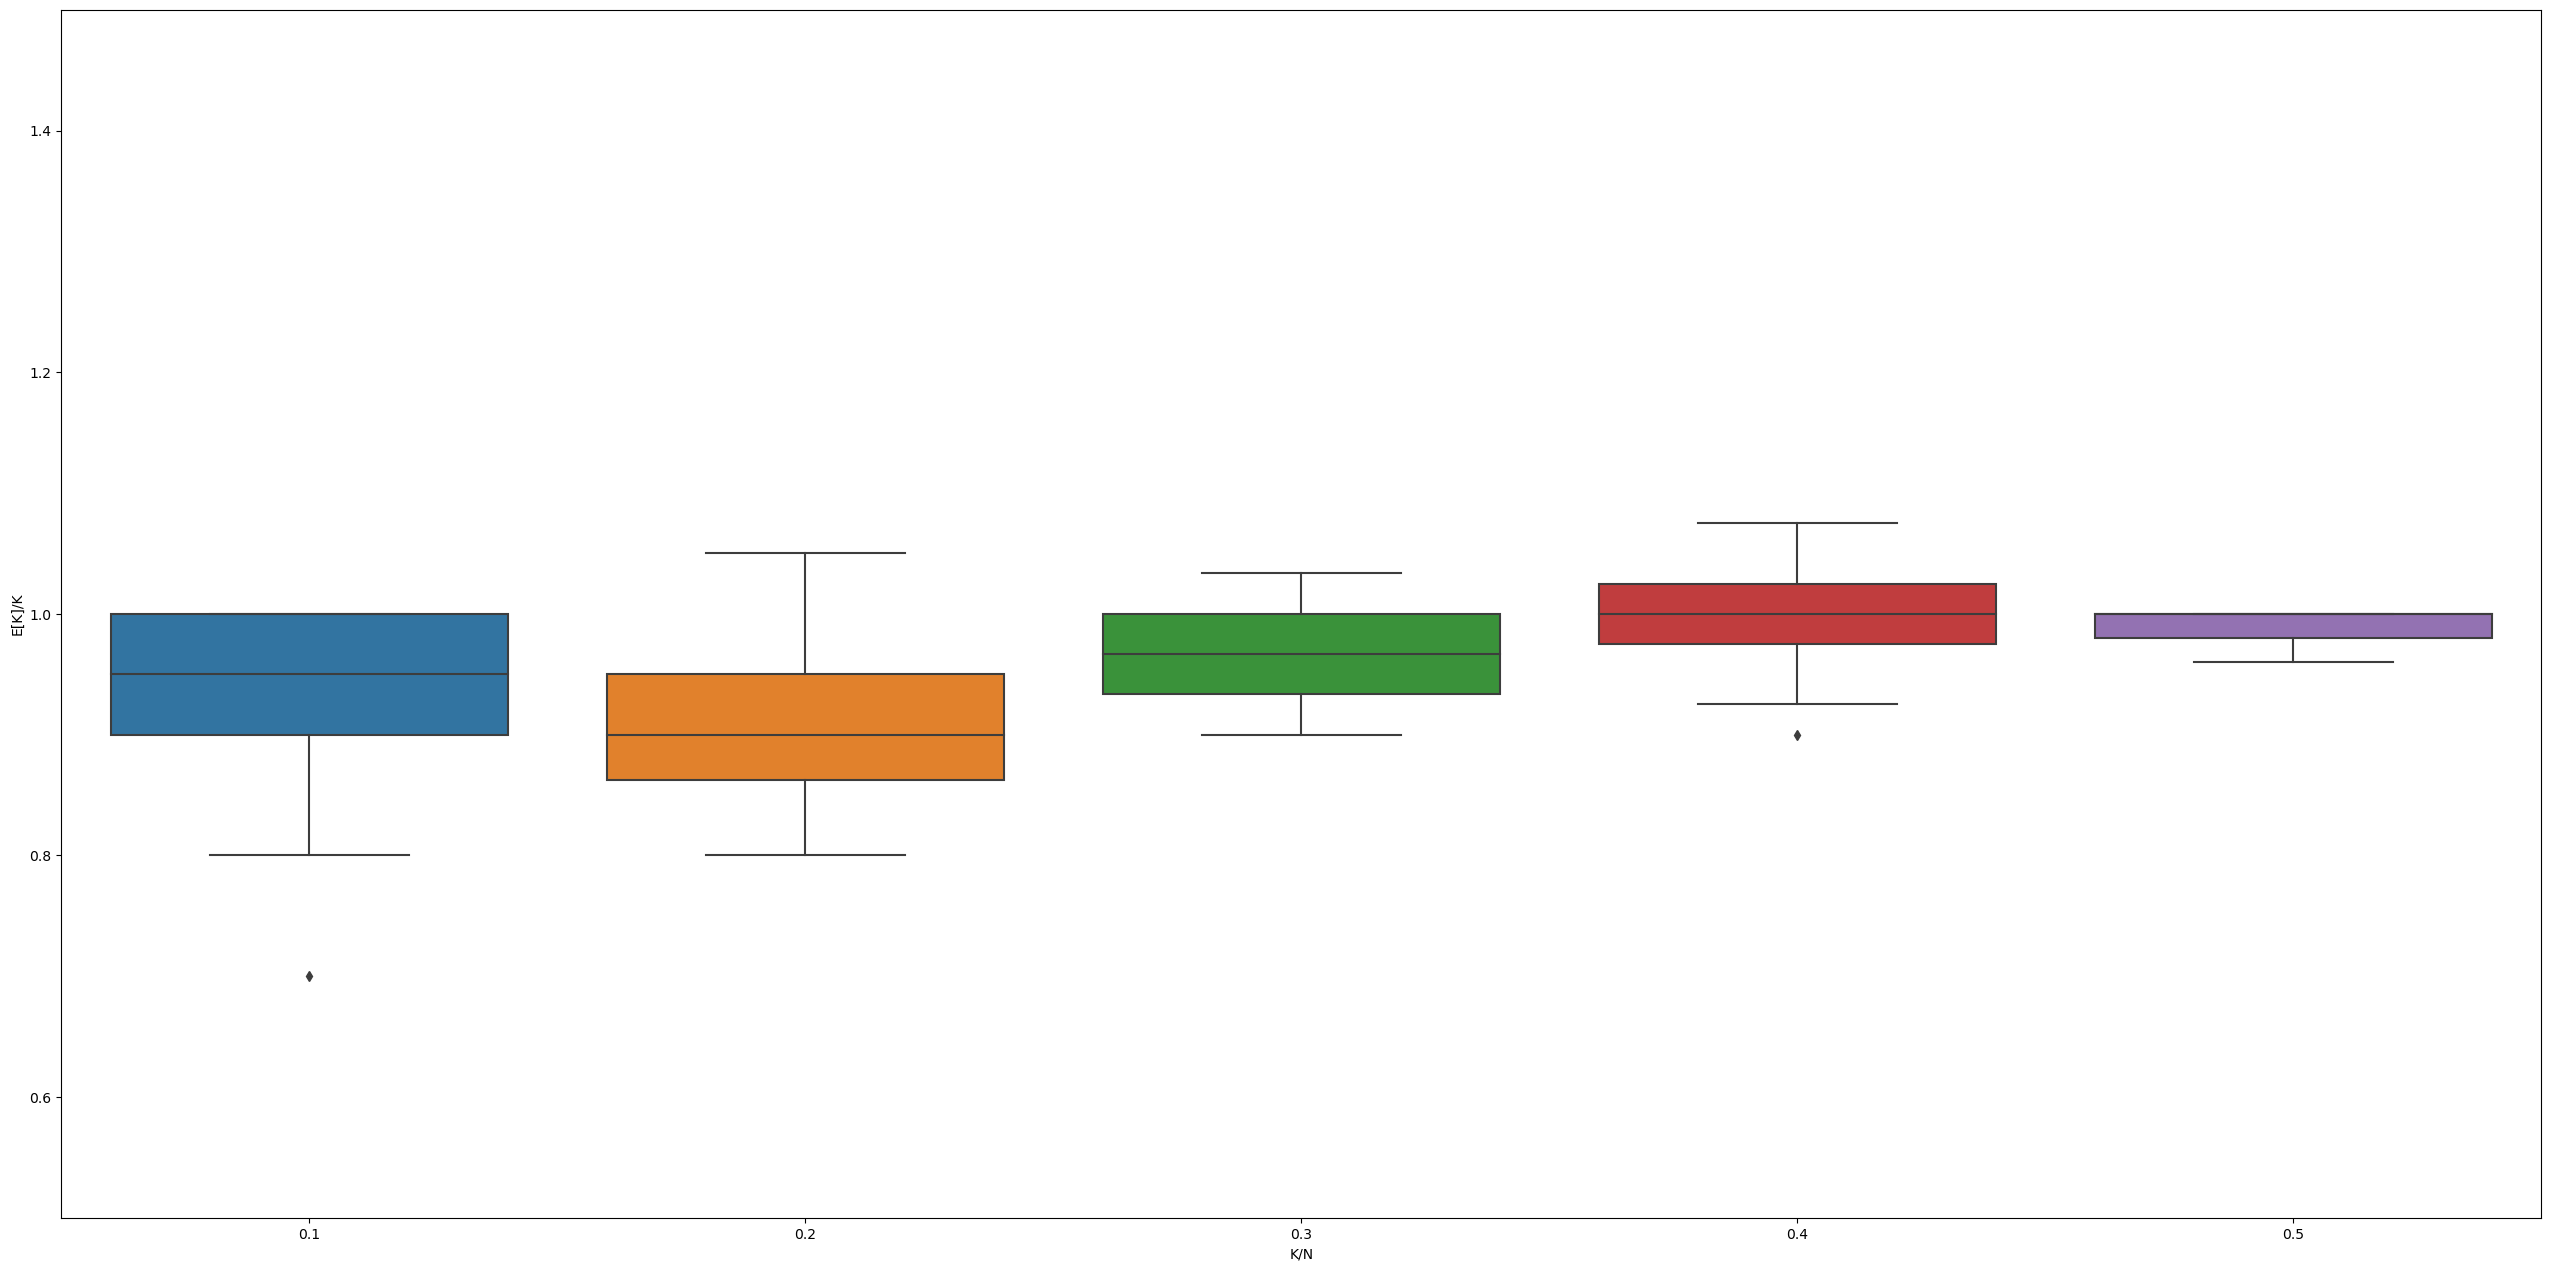

In [10]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=data);
plt.ylim(0.5, 1.5);

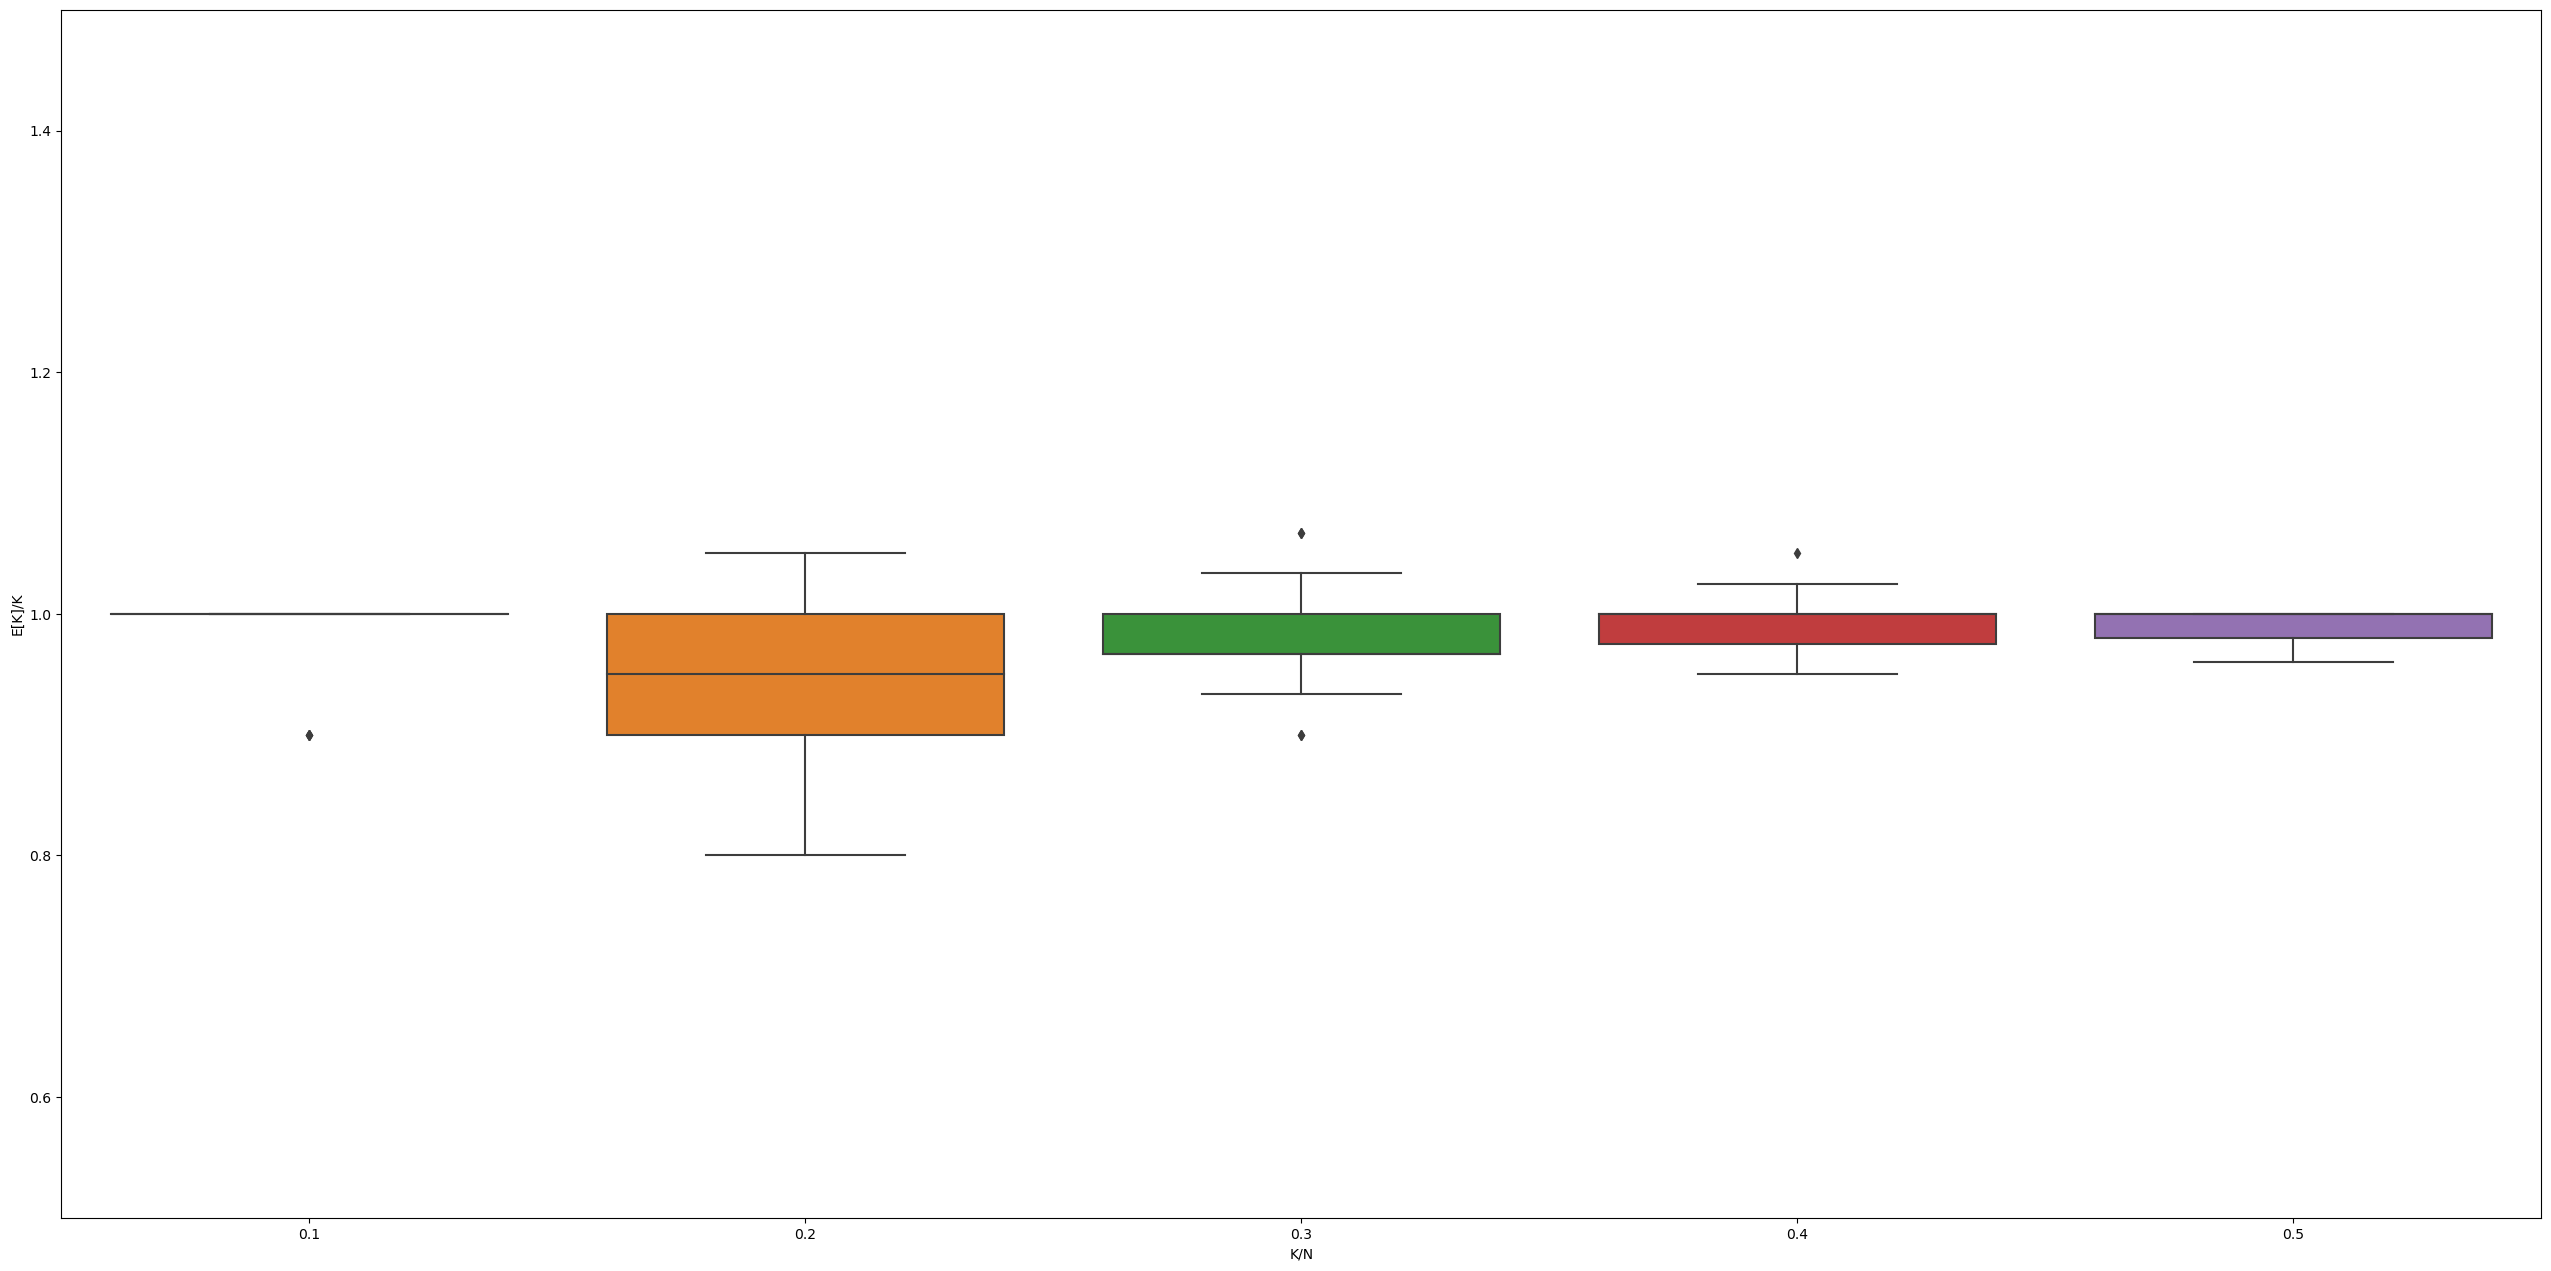

In [11]:
import seaborn as sns

tips = sns.load_dataset("tips")
sns.boxplot(x="K/N", y="E[K]/K", data=top_data);
plt.ylim(0.5, 1.5);